<a href="https://colab.research.google.com/github/hangjoni/ai-notebooks/blob/main/WWF_L2_Low_Level_API_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lesson [page](https://walkwithfastai.com/revisited/low_level.html)

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.MNIST); path, path.ls()

(Path('/root/.fastai/data/mnist_png'),
 (#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')])

In [5]:
items = get_image_files(path)
items[:10]

(#10) [Path('/root/.fastai/data/mnist_png/training/2/52319.png'),Path('/root/.fastai/data/mnist_png/training/2/10291.png'),Path('/root/.fastai/data/mnist_png/training/2/23826.png'),Path('/root/.fastai/data/mnist_png/training/2/12302.png'),Path('/root/.fastai/data/mnist_png/training/2/30762.png'),Path('/root/.fastai/data/mnist_png/training/2/21436.png'),Path('/root/.fastai/data/mnist_png/training/2/41417.png'),Path('/root/.fastai/data/mnist_png/training/2/17265.png'),Path('/root/.fastai/data/mnist_png/training/2/17757.png'),Path('/root/.fastai/data/mnist_png/training/2/6168.png')]

In [10]:
len(items), len((path/'training'/'1').ls())

(70000, 6742)

get_image_files grab from all sub-folders by default. i.e. both /training and /testing folders

In [14]:
count_train = 0
count_valid = 0
for i in range(10):
  dir_train = path/'training'/str(i)
  dir_valid = path/'testing'/str(i)
  count_train += len(dir_train.ls())
  count_valid += len(dir_valid.ls())
count_train, count_valid

(60000, 10000)

Last lesson, we use Pillow to open the image. As reminder, this was how

In [17]:
from PIL import Image
im = Image.open(items[0])
im

Now we'll try opening the image using Fastai built in class

In [18]:
im = PILImageBW.create(items[0])
im

Alternatively, im.show() works with PILImageBW. 

It shows image in a nice way: making it larger, inverting the black and white to be more human-friendly

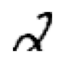

In [20]:
im.show();

In [21]:
splitter = GrandparentSplitter(
    train_name="training",
    valid_name="testing"
)

In [22]:
splits = splitter(items)

In [23]:
len(splits), len(splits[0]), len(splits[1])

(2, 60000, 10000)

In [25]:
splits[0][0], splits[1][100]

(0, 60100)

splitter returns a tuple of 2 list of indexes on the input items.

Basically it decide whether each item in the input items belong to the first or the second bucket

In [29]:
s0 = pd.DataFrame(splits[0] + splits[1], columns=['s0'])
s0['s0'].nunique()

70000

### Datasets

So far we have gathered all our filename into a list called items

Then splits hold the index (of items) that decide which bucket does each item belong to

Datasets gonna hold all that logic together

In [30]:
dsrc = Datasets(
    items,
    tfms=[[PILImageBW.create], [parent_label, Categorize]],
    splits=splits
)

parent_label is a fastai convenience that returns the label for the given image filename by using the name of the parent folder

In [41]:
dsrc.train[0]

(PILImageBW mode=L size=28x28, TensorCategory(2))

In [36]:
dsrc.valid

(#10000) [(PILImageBW mode=L size=28x28, TensorCategory(2)),(PILImageBW mode=L size=28x28, TensorCategory(2)),(PILImageBW mode=L size=28x28, TensorCategory(2)),(PILImageBW mode=L size=28x28, TensorCategory(2)),(PILImageBW mode=L size=28x28, TensorCategory(2)),(PILImageBW mode=L size=28x28, TensorCategory(2)),(PILImageBW mode=L size=28x28, TensorCategory(2)),(PILImageBW mode=L size=28x28, TensorCategory(2)),(PILImageBW mode=L size=28x28, TensorCategory(2)),(PILImageBW mode=L size=28x28, TensorCategory(2))...]

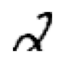

In [44]:
dsrc.train[0][0].show();

Datasets create a .train and .valid attribute on the returned dataset. 

Each contains a list of tuple (image, label)

tfms variable in Datasets() specify list of transforms to be applied to the returned tuple - image and label respectively

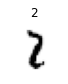

In [46]:
show_at(dsrc.train,3);

### DataLoaders

In [47]:
item_tfms = [CropPad(34), RandomCrop(size=28), ToTensor()]

In [48]:
batch_tfms = [IntToFloatTensor(), Normalize()]

In [50]:
dls = dsrc.dataloaders(
    bs=128,
    after_item=item_tfms,
    after_batch=batch_tfms
)

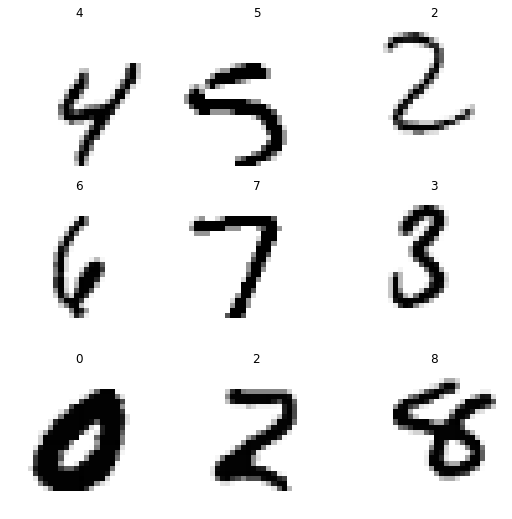

In [51]:
dls.show_batch()

Question: is one_batch deterministic or reshuffled?

It is deterministic if called on dls.valid, since the data is not shuffled

It is not deterministic if called on dls.train or dls (which defaults to dls.train?)

In [52]:
xb, yb = dls.one_batch()

In [55]:
xb2, yb2 = dls.one_batch()

In [64]:
(xb[0] == xb2[0]).all()

TensorImageBW(False)

In [59]:
xb4, yb4 = dls.valid.one_batch()

In [65]:
(xb == xb4).all()

TensorImageBW(False)

In [66]:
xb5, yb5 = dls.valid.one_batch()

In [67]:
(xb4 == xb5).all()

TensorImageBW(True)

Checking number of classes

In [68]:
dls.c

10

Building a Model and Training